# **Importing The Libraries**

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Loading The Data for Modelling**

In [ ]:
import pickle

# 1. Load the processed arrays
print("Loading data arrays...")
data = np.load('processed_data.npz')
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

# 2. Load metadata
print("Loading metadata...")
with open('metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

label_lookup = metadata['label_lookup']
reverse_lookup = metadata['reverse_lookup']
num_classes = metadata['num_classes']
IMG_SIZE = metadata['IMG_SIZE']

# 3. Re-initialize the Data Augmentation (Generators)
# Note: We define the generator logic here based on the data loaded
train_datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.20,
    height_shift_range=0.20,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator() # No augmentation for validation

# 4. Create the flow from the loaded data
train_gen = train_datagen.flow(X_train, y_train, batch_size=64, shuffle=True)
val_gen = val_datagen.flow(X_val, y_val, batch_size=64)

print(f"✅ Setup Complete.")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Validation Samples: {X_val.shape[0]}")
print(f"Number of Classes: {num_classes}")
print("You can now proceed to build_cnn()")

Loading data arrays...
Loading metadata...
✅ Setup Complete.
Training Samples: 14000
Validation Samples: 3000
Number of Classes: 10
You can now proceed to build_cnn()


# **Modelling**

In [ ]:
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.30),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.40),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.50),

        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0008)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
model = build_cnn((IMG_SIZE, IMG_SIZE, 1), num_classes)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,714,602 (25.61 MB)

 Trainable params: 6,713,194 (25.61 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6)
]

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 67s 215ms/step - accuracy: 0.2636 - loss: 2.4317 - val_accuracy: 0.1000 - val_loss: 6.4804 - learning_rate: 8.0000e-04
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 28s 126ms/step - accuracy: 0.7106 - loss: 0.8256 - val_accuracy: 0.1000 - val_loss: 7.1751 - learning_rate: 8.0000e-04
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 29s 131ms/step - accuracy: 0.8804 - loss: 0.3715 - val_accuracy: 0.3293 - val_loss: 5.4701 - learning_rate: 8.0000e-04
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.9307 - loss: 0.2282 - val_accuracy: 0.3330 - val_loss: 6.1631 - learning_rate: 8.0000e-04
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 28s 127ms/step - accuracy: 0.9565 - loss: 0.1470 - val_accuracy: 0.7050 - val_loss: 1.1070 - learning_rate: 8.0000e-04
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.9699 - loss: 0.1019 - val_accuracy: 0.6110 - val_loss: 3.8098 - learning_rate: 8.0000e-04
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 29s 131ms/step - 

**Model Performance**

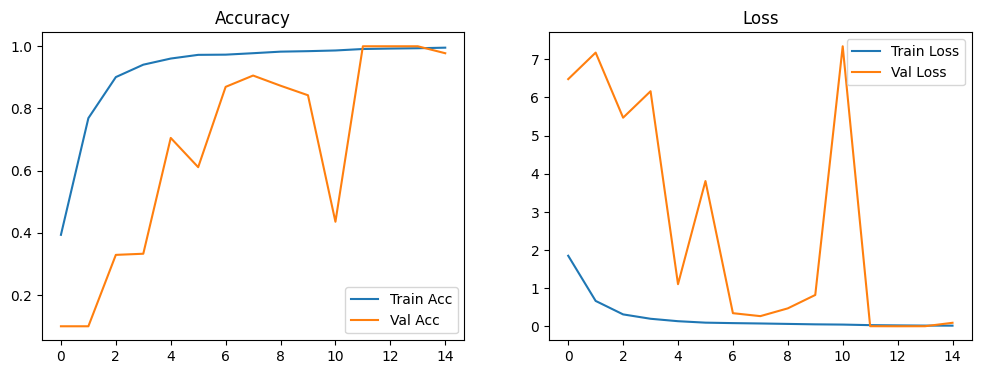

In [ ]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_df["accuracy"], label="Train Acc")
plt.plot(history_df["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df["loss"], label="Train Loss")
plt.plot(history_df["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()
plt.show()

**Test Accuracy**

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", round(test_acc * 100, 2), "%")
print("Test Loss:", test_loss)

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 1.0000 - loss: 0.0020
Test Accuracy: 100.0 %
Test Loss: 0.0019936785101890564


In [ ]:
y_pred = model.predict(X_test)
y_pred_int = np.argmax(y_pred, axis=1)
y_true_int = np.argmax(y_test, axis=1)

target_names = [reverse_lookup[i] for i in range(num_classes)]

print(classification_report(y_true_int, y_pred_int, target_names=target_names))

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       300
         02_l       1.00      1.00      1.00       300
      03_fist       1.00      1.00      1.00       300
04_fist_moved       1.00      1.00      1.00       300
     05_thumb       1.00      1.00      1.00       300
     06_index       1.00      1.00      1.00       300
        07_ok       1.00      1.00      1.00       300
08_palm_moved       1.00      1.00      1.00       300
         09_c       1.00      1.00      1.00       300
      10_down       1.00      1.00      1.00       300

     accuracy                           1.00      3000
    macro avg       1.00      1.00      1.00      3000
 weighted avg       1.00      1.00      1.00      3000



**Confusion Matrix**

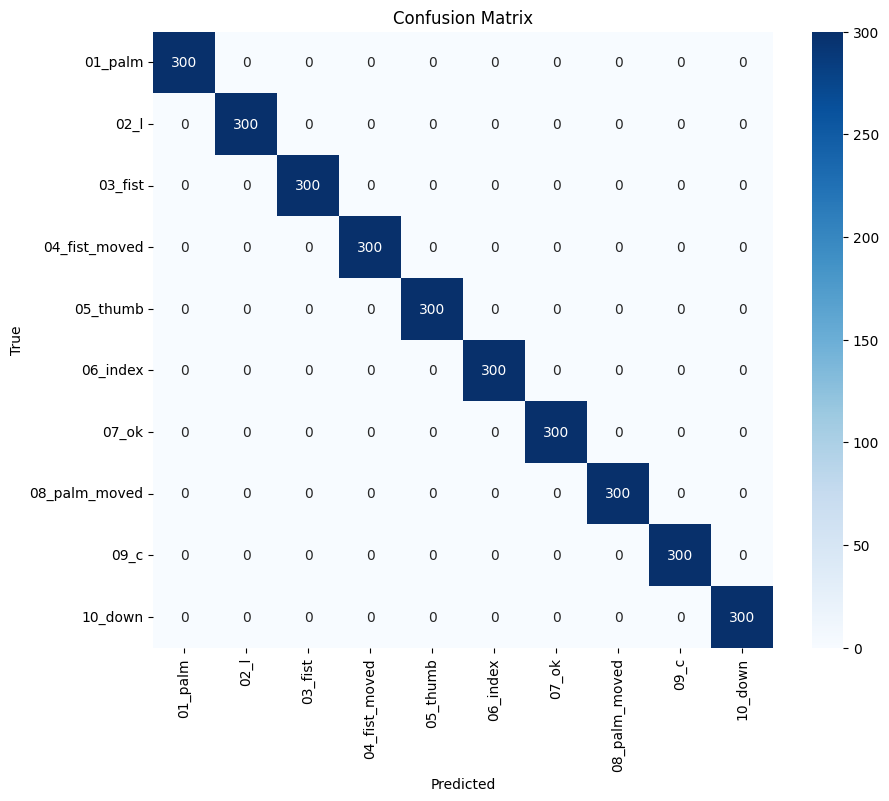

In [ ]:
cm = confusion_matrix(y_true_int, y_pred_int)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Save the model to a single file
# .keras is the modern, zipped format for TensorFlow 2.x
model.save('hand_gesture_model.keras')

print("Model saved successfully as 'hand_gesture_model.keras'")

Model saved successfully as 'hand_gesture_model.keras'
